In [5]:
# Sully Smith, Seymour High School
# This is my cleaned up version of reading the waterbox.pdb file. 
# We use genfromtext to extract data from the mixed ascii / float data file 
# Mentors: Nick Hagerty and Dilip Asthagiri
import numpy as np 
import matplotlib.pyplot as plt 
import MDAnalysis as md

C:\Users\ssk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dtype=[
    ('record','U6'),
    ('atom_id','i4'),
    ('atom_name','U4'),
    ('res_name','U4'),
    ('res_id','i4'),
    ('x','f8'),
    ('y','f8'),
    ('z','f8'),
    ('occupancy','f8'),
    ('temp_factor','f8'),
    ('segment','U6')
]

In [9]:
data = md.Universe('w4096.psf','sample.dcd')
# Box length given by DA 
Boxlength = 24.86 
print(data)


<Universe with 12288 atoms>


In [ ]:
data.trajectory[0]  # Set to the first frame
# Extracting atom data
atomname = data.atoms.names
resid = data.atoms.resids           
positions = data.atoms.positions    
# Extracting x, y, z coordinates
xcoord = positions[:, 0]
ycoord = positions[:, 1]
zcoord = positions[:, 2]
# Number of atoms
natoms = len(atomname)
# Selecting every 3rd atom 
selected_idx = np.arange(0, natoms, 3)
# Combining into a coordinate array, shape (natoms, 3)
coord = positions
coord_selected = coord[selected_idx]

In [24]:
# To partition with all bins with positive indices, we will need to move the box by boxlength/2 in all dimensions
coord = coord + Boxlength/2.0

In [25]:
# defining bins
x_bins = 3
y_bins = 3
z_bins = 3 
x_max = np.max(xcoord)
y_max = np.max(ycoord)
z_max = np.max(zcoord)
x_min = np.min(xcoord)
y_min = np.min(ycoord)
z_min = np.min(zcoord)
x_dist = (x_max-x_min)/(x_bins)
y_dist = (y_max-y_min)/(y_bins)
z_dist = (z_max-z_min)/(z_bins)
boxes = [[] for i in range(x_bins*y_bins*z_bins)]
def get_box_idx (x,y,z):
	idx= x+y*x_bins+z*(y_bins*x_bins)
	return idx

In [26]:
for i in selected_idx:
	# figure out what bin each atom is in
	xbox_local = int((xcoord[i] - x_min)/x_dist)
	ybox_local = int((ycoord[i] - y_min)/y_dist)
	zbox_local = int((zcoord[i] - z_min)/z_dist)
	# print(f'x_box_local={xbox_local}, y_box_local={ybox_local},z_box_local={zbox_local}')
	boxidx = min(get_box_idx(xbox_local,ybox_local,zbox_local), x_bins*y_bins*z_bins-1)
	# print(boxidx) 
	boxes[boxidx].append(i)
# print(boxes)

In [27]:
# These indices correspond to positions in your coordinate arrays: xcoord, ycoord, and zcoord.
def euclidean_distance(i, j):
    # This computes the difference in y-coordinates between atom i and atom j.
    dx = coord[i] - coord[j]
    # I returned the final distance between atoms i and j.
    # You could use np.linalg.norm
    # or dot products
    return np.sqrt(np.dot(dx,dx))
# This function calculated the straight-line distance between two atoms, based on their coordinates.

In [28]:
pairwise_distances = []

for box in boxes:
	# This loops through each 3D spatial bin (a list of atom indices).
	for i in range(0, len(box), 3):
		# This loops through every atom in the current box using its index in the box list.
		for j in range(i + 3, len(box), 3):  # Avoids duplicates and self-pairs
			idx1 = box[i]
			idx2 = box[j]
			# Gets the actual atom indices from the box.
			dist = euclidean_distance(idx1, idx2)  
			pairwise_distances.append((idx1, idx2, dist))

In [29]:
# I am extracting only the distances from the tuple (i, j, dist)
distances = [dist for (_, _, dist) in pairwise_distances]

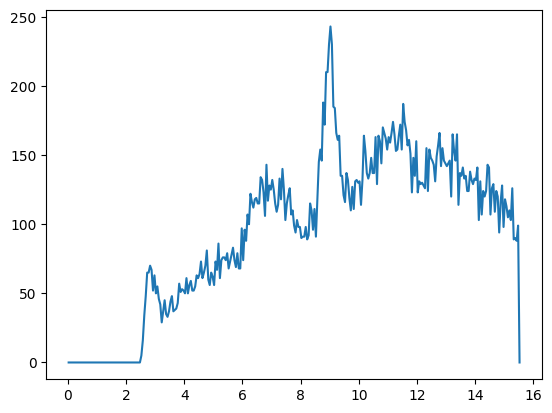

In [30]:
# Writing my own histogramming code 
delr = 0.05 
nbins = int((15.5/delr) + 1)
hist = np.zeros(nbins)
r    = np.zeros(nbins)

for rcurrent in distances:
    if rcurrent < 15.5:
        bin = int(rcurrent / delr) 
        hist[bin] += 1 
for i in range(nbins):
    rlow = i * delr 
    rmid = rlow + delr / 2.0 
    r[i] = rmid 
plt.plot(r,hist)


In [31]:
hist_s = np.zeros_like(hist)

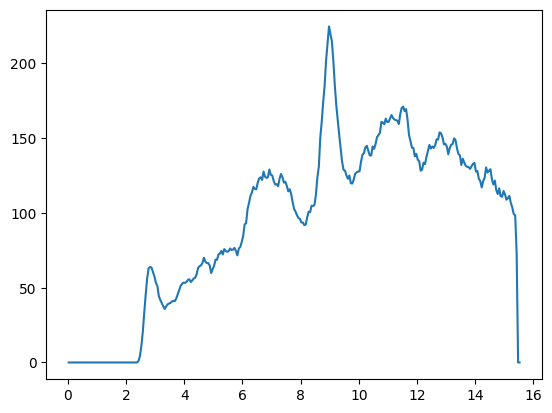

In [32]:
# This makes it to where you can imput any radius, and it will make it smoother depending
# on how large the number is
smoothing_radius = 2
for i in range(smoothing_radius, nbins - smoothing_radius):
    smooth = hist[i - smoothing_radius : i + smoothing_radius + 1]
    hist_s[i] = np.mean(smooth)
plt.plot(r, hist_s)